<a href="https://colab.research.google.com/github/gecitemre/403-the2/blob/main/Copy_of_CENG403_2025_Spring_THE2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Take-Home Exam 2 (THE-2)**
## CENG403 - Spring 2025

In this THE, we will focus on implementing a CNN and an RNN from scratch or using PyTorch:

*   Task 1: Implementing a forward function of your own deformable CNN from scratch (30 pts).
*   Task 2: Implementing CNN in PyTorch (40 pts).
*   Task 3: Implementing RNN using torch.autograd (30 pts).

**Getting Ready**

You can use the following tutorials if you need more details about the libraries/tools you will use:

*   **Jupyter Notebook and Colab**:
 * https://www.dataquest.io/blog/jupyter-notebook-tutorial/
 * https://colab.research.google.com/
* **NumPy**
 * https://numpy.org/devdocs/user/quickstart.html
* **PyTorch**:
 * https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html


## **Task 1: Implement a Forward Pass of Your Own Deformable CNN (30 Points)**

In this task, you are responsible for implementing the forward pass of [deformable convolution v2](https://arxiv.org/abs/1811.11168).

**Note that you should implement all functions from scratch! Using PyTorch or any other libraries except for `numpy` in your implementation will be evaluated as 0 (zero).**


### **1.1 Forward Pass Implementation (30 Points)**

Standard convolution (along one dimension of the input layer) with a filter size of $K$ at location $\mathbf{p}_0$ can be formally defined as:

$$
\mathbf{a}^{l+1}(\mathbf{p}_0) = \sum_{k=0}^{K-1}  \mathbf{w}(k) \cdot \mathbf{a}^l(\mathbf{p}_0 + \mathbf{p}_k),
$$

where:

*    $\mathbf{a}^l$ is the input feature map,
*    $\mathbf{a}^{l+1}$ is the output feature map,
*    $\mathbf{w}$ is the convolution kernel,
*    $\mathbf{p}_k$ is the fixed offset of the $k$-th sampling location (e.g., for a 1D feature map and a filter size of 3, $\mathbf{p}_k \in \{0, 1, 2\}$).


Deformable convolution v2 introduces learnable offsets $\Delta \mathbf{p}_k$ and modulation scalars $m_k \in [0,1]$:

$$
\mathbf{a}^{l+1}(\mathbf{p}_0) = \sum_{k=0}^{K-1} \mathbf{w}(k) \cdot \left( m_k \cdot \mathbf{a}^l(\mathbf{p}_0 + \mathbf{p}_k + \Delta \mathbf{p}_k) \right),
$$

where:

*    $\Delta \mathbf{p}_k$ are learned dynamic offsets,
*    $m_k$ are learned modulation scalars (also called a mask).

Since $\mathbf{p}_0 + \mathbf{p}_k + \Delta \mathbf{p}_k$ may be fractional, bilinear interpolation is used. For any fractional position $\mathbf{q}$ with $x$ and $y$ coordinates  $\mathbf{q} = (q_x, q_y)$, we first identify the closest integer positions:

$$
\begin{aligned}
\mathbf{p}_{\text{lt}} &= (\lfloor q_x \rfloor, \lfloor q_y \rfloor) \quad \text{(left top)}, \\
\mathbf{p}_{\text{rt}} &= (\lceil q_x \rceil, \lfloor q_y \rfloor) \quad \text{(right top)}, \\
\mathbf{p}_{\text{lb}} &= (\lfloor q_x \rfloor, \lceil q_y \rceil) \quad \text{(left bottom)}, \\
\mathbf{p}_{\text{rb}} &= (\lceil q_x \rceil, \lceil q_y \rceil) \quad \text{(right bottom)},
\end{aligned}
$$

where $\lfloor \cdot \rfloor$ denotes rounding down, and $\lceil \cdot \rceil$ rounding up to the closest integer.

Given these closest integer positions, bilinear interpolation for a fractional position $\mathbf{q}$ can be defined as:

$$
\mathbf{a}(\mathbf{q}) = \sum_{\mathbf{p}_i \in \{\mathbf{p}_{\text{lt}}, \mathbf{p}_{\text{rt}}, \mathbf{p}_{\text{lb}}, \mathbf{p}_{\text{rb}}\}} G(\mathbf{p}_i, \mathbf{q}) \cdot \mathbf{a}(\mathbf{p}_i),
$$

where the bilinear interpolation weight $G(\mathbf{p}, \mathbf{q})$ is:

$$
G(\mathbf{p}, \mathbf{q}) = (1 - |{p}_x - {q}_{x}|) \cdot (1 - |{p}_y - {q}_{y}|).
$$

With these definitions, we can write down deformable convolution in a complete form as follows:

$$
\mathbf{a}^{l+1}(\mathbf{p}_0) = \sum_{k=0}^{K-1} \mathbf{w}(k) \cdot m_k \cdot \left( \sum_{\mathbf{p}_i} G(\mathbf{p}_i, \mathbf{p}_0 + \mathbf{p}_k + \Delta \mathbf{p}_k) \cdot \mathbf{a}^l(\mathbf{p}_i) \right).
$$

For more details, please check the [paper](https://arxiv.org/abs/1811.11168) or [this tutorial](https://pub.towardsai.net/review-dcnv2-deformable-convnets-v2-object-detection-instance-segmentation-3d8a18bee2f5).

You are expected to complete the given `deformable_conv2d_np()` function.

**Do not change functions arguments and return value.**

In [ ]:
import numpy as np

def bilinear_interpolate(a_l, q_y, q_x):
    """
    Perform bilinear interpolation on the input activation map at the given (fractional) coordinates.

    Args:
        a_l (np.ndarray): 2D array of shape (H, W) representing the activation map (feature map) at a certain layer.
        q_y (float): Y-coordinate (row index) where interpolation is to be performed.
        q_x (float): X-coordinate (column index) where interpolation is to be performed.

    Returns:
        out (np.ndarray): Interpolated value at (q_x, q_y).
    """
    #######################################################
    # Implement bilinear interpolation
    #######################################################

    H, W = a_l.shape

    y0_f = np.floor(q_y)
    x0_f = np.floor(q_x)
    y0 = int(y0_f)
    x0 = int(x0_f)
    y1 = y0 + 1
    x1 = x0 + 1

    # Fractional parts (distances from top-left integer coord)
    # dx = q_x - floor(q_x)
    # dy = q_y - floor(q_y)
    dy = q_y - y0_f
    dx = q_x - x0_f

    # Get values of the four corners, with zero padding for out-of-bounds
    # a_l[y, x] is accessed safely. If y or x is out of bounds [0, H-1] or [0, W-1], value is 0.0.
    val_lt = a_l[y0, x0] if (0 <= y0 < H and 0 <= x0 < W) else 0.0
    val_rt = a_l[y0, x1] if (0 <= y0 < H and 0 <= x1 < W) else 0.0
    val_lb = a_l[y1, x0] if (0 <= y1 < H and 0 <= x0 < W) else 0.0
    val_rb = a_l[y1, x1] if (0 <= y1 < H and 0 <= x1 < W) else 0.0

    # Interpolate using the standard formula:
    # V = V_lt * (1-dx)(1-dy) + V_rt * dx(1-dy) + V_lb * (1-dx)dy + V_rb * dx*dy
    out = (val_lt * (1 - dx) * (1 - dy) +
           val_rt * dx * (1 - dy) +
           val_lb * (1 - dx) * dy +
           val_rb * dx * dy)
    return out

def deform_conv2d_np(a_l, delta, mask, weight, stride=1, padding=0, dilation=1):
    """
    Deformable Conv2D v2 operation (forward pass) implemented in NumPy.
    Args:
        a_l (np.ndarray): Input feature map of shape (N, C_in, H_in, W_in)
        delta (np.ndarray): Offsets of shape (N, 2 * K_h * K_w, H_out, W_out)
        mask (np.ndarray): Modulation masks of shape (N, K_h*K_w, H_out, W_out)
        weight (np.ndarray): Convolution kernel of shape (C_out, C_in, K_h, K_w)
        stride (int): Stride of the convolution
        padding (int): Zero-padding
        dilation (int): Dilation factor
    Returns:
        out (np.ndarray): Output feature map of shape (N, C_out, H_out, W_out)
    """
    #######################################################
    # Step 1: Preparing hyperparameters, pad input, and initialize output
    #######################################################
    N, C_in, H_in, W_in = a_l.shape
    C_out, _, K_h, K_w = weight.shape
    # Output spatial dims
    H_out = ((H_in + 2 * padding - dilation * (K_h - 1) - 1) // stride) + 1
    W_out = ((W_in + 2 * padding - dilation * (K_w - 1) - 1) // stride) + 1
    # Pad input
    if padding > 0:
        a_l_padded = np.pad(a_l, ((0,0),(0,0),(padding,padding),(padding,padding)), mode='constant')
    else:
        a_l_padded = a_l
    H_pad, W_pad = a_l_padded.shape[2:]
    # Output tensor
    out = np.zeros((N, C_out, H_out, W_out), dtype=a_l.dtype)

    #######################################################
    # Step 2: Iterating over all coordinates
    # HINT: You should constuct nested loops considering all dimensions of input and kernel
    #######################################################
    for n in range(N):
        for c_out in range(C_out):
            for h_out in range(H_out):
                for w_out in range(W_out):
                    for c_in in range(C_in):
                        for k_h in range(K_h):
                            for k_w in range(K_w):
                                #######################################################
                                # Step 3: Calculating delta (offset) and mask
                                #######################################################
                                # Delta contains (dy, dx) for each kernel location; mask contains modulation strength.

                                # Index for delta and mask
                                k_idx = k_h * K_w + k_w
                                # Offsets for this kernel position
                                delta_y = delta[n, 2 * k_idx + 0, h_out, w_out]
                                delta_x = delta[n, 2 * k_idx + 1, h_out, w_out]
                                m = mask[n, k_idx, h_out, w_out]

                                #######################################################
                                # Step 4: Computing the deformed sampling position
                                #######################################################
                                # Compute the deformed sampling position

                                # Base position in padded input
                                y = h_out * stride + k_h * dilation
                                x = w_out * stride + k_w * dilation

                                # Add offset
                                y_sample = y + delta_y
                                x_sample = x + delta_x

                                #######################################################
                                # Step 5: Bilinear interpolation from the input feature map
                                #######################################################
                                # Use bilinear interpolation to sample nearby pixel values.

                                # Sample from the padded input
                                val = bilinear_interpolate(a_l_padded[n, c_in], y_sample, x_sample)

                                #######################################################
                                # Step 6: Applying the convolution weight and modulation mask
                                #######################################################
                                # Multiply interpolated value by the learned weight and the modulation scalar.
                                out[n, c_out, h_out, w_out] += weight[c_out, c_in, k_h, k_w] * m * val

    return out


### **1.2 Validate Implementations in Sections 1.1**

Run the following cell to validate/check whether your implementations in Sections 1.1 are correct. You will see your grade calculated for this part.

**Do not change/add any code here.**

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from torchvision.ops import deform_conv2d
np.random.seed(0)
torch.manual_seed(0)

# --- Define parameters ---
N, C_in, H_in, W_in = 1, 3, 5, 5
C_out, K_h, K_w = 2, 3, 3
stride, padding, dilation = 1, 0, 1

# Input
np_input = np.arange(N * C_in * H_in * W_in, dtype=np.float32).reshape(N, C_in, H_in, W_in)
torch_input = torch.tensor(np_input, dtype=torch.float32)

# Offset: zero (no deformation)
np_offset = np.random.rand(N, 2 * K_h * K_w, 3, 3).astype(np.float32)
torch_offset = torch.tensor(np.copy(np_offset), dtype=torch.float32)

# Mask: ones (no modulation)
np_mask = np.ones((N, K_h * K_w, 3, 3), dtype=np.float32)
torch_mask = torch.tensor(np_mask, dtype=torch.float32)

# Weight: center=1
np_weight = np.random.rand(C_out, C_in, K_h, K_w).astype(np.float32)
torch_weight = torch.tensor(np.copy(np_weight), dtype=torch.float32)

# Bias: zero
np_bias = np.zeros((C_out), dtype=np.float32)
torch_bias = torch.tensor(np.copy(np_bias), dtype=torch.float32)

# --- Run NumPy Deformable Conv ---
np_output = deform_conv2d_np(np_input, np_offset, np_mask, np_weight,
                             stride=stride, padding=padding, dilation=dilation)

# --- Run PyTorch Deformable Conv ---
torch_output = deform_conv2d(
    input=torch_input,
    offset=torch_offset,
    weight=torch_weight,
    bias=torch_bias,
    stride=stride,
    padding=padding,
    dilation=dilation,
    mask=torch_mask
)

# --- Compare outputs ---
print("NumPy Output:\n", np_output[0, 0])
print("PyTorch Output:\n", torch_output[0, 0].detach().numpy())

grade = 0
if (np.allclose(np_output, torch_output.detach().numpy(), atol=1e-4) == True):
    grade = 30
else:
    grade = 0
print(" Your grade is ", grade, "/30.")

NumPy Output:
 [[454.93646 478.6857  422.1958 ]
 [531.8982  538.29285 478.7652 ]
 [474.43445 463.66626 392.68332]]
PyTorch Output:
 [[454.93646 478.6857  422.1958 ]
 [531.8982  538.2928  478.7652 ]
 [474.43445 463.66623 392.68332]]
 Your grade is  30 /30.


## **Task 2. Implement a CNN in PyTorch (40 pts)**

In this task, you are expected to implement a training, validation and testing pipeline for a CNN model using PyTorch. You will work with CIFAR100 dataset which is available in torchvision.dataset.


### **2.1 Implementing DataLoader (2.5 Points)**
In this task, you should implement a dataloader for CIFAR100 dataset. It is  a built-in dataset in the torchvision.datasets module, i.e. **you do not need to implement custom dataloader**.  Here, you can find examples about how a built-in dataset can be used:

*   https://pytorch.org/vision/main/datasets.html

The official CIFAR100 dataset contains only training and test splits. Therefore, you are expected to create a validation split from training data randomly, with **80% used for training** and **the remaining 20% reserved for validation**.


In [ ]:
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms

# Create DataLoader
batch_size = 64

# Define transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
])

transform_validationAndtest = transforms.Compose([
    transforms.ToTensor(),
])


# Define full training set
full_train_set = CIFAR100(root='./data', train=True, download=True, transform=transform_train)


# Calculate split lengths , Perform split
train_size = int(0.8 * len(full_train_set))
val_size = len(full_train_set) - train_size

train_set, val_set = random_split(full_train_set, [train_size, val_size]) # @TODO: Modify this line

# Update val_set transform to use validation transform
val_set.dataset.transform = transform_validationAndtest

# Define Data loaders for training and validation splits
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2) # Modify this line
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2) # Modify this line

# Define Test set and loader.
test_set = CIFAR100(root='./data', train=False, download=True, transform=transform_validationAndtest) # Modify this line
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2) #  Modify this line

# Print Split Ratios
print(f"Total samples in CIFAR-100 training set: {len(full_train_set)}")
print(f"Training split: {len(train_set)} samples ({len(train_set)/len(full_train_set)*100:.2f}%)")
print(f"Validation split: {len(val_set)} samples ({len(val_set)/len(full_train_set)*100:.2f}%)")
print(f"Test split: {len(test_set)} samples")

100%|██████████| 169M/169M [00:03<00:00, 48.6MB/s]


Total samples in CIFAR-100 training set: 50000
Training split: 40000 samples (80.00%)
Validation split: 10000 samples (20.00%)
Test split: 10000 samples


### **2.2 Implement a CNN Model (2.5 Points)**
In this task, you are expected to implement CustomCNN class according to the following specifications:

*   Use at least three Conv2d Layers,
*   Use at least one Pooling2d layer,
*   Use at least two fully-connected layers,
*   Do not use any normalization layer.

There are no limitations for the model as long as you follow the above specifications.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, norm_layer= None):
        super(CustomCNN, self).__init__()

        # Define layers of CNN. Do not forget to follow model specifications!.
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)  # After two poolings on 32x32 input: 8x8
        self.fc2 = nn.Linear(256, 100)


    def forward(self, x):

        # Implement the forward pass
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


# Create model instance
model = CustomCNN()

# Print model summary
print(model)

CustomCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=100, bias=True)
)


###**2.3 Define Your Optimizer and Loss function**
This task involves setting up a loss function and an optimizer for training a model. The loss function measures prediction accuracy. The optimizer, such as SGD or Adam, updates model weights based on the loss. Key parameters like learning rate and weight decay should be set appropriately. The model must also be moved to the correct device (CPU/GPU) before training.

Here, you can reuse the relevant bit of your solution to THE1.


In [ ]:
import torch.optim as optim

# Define a loss function
loss_function = torch.nn.CrossEntropyLoss()

# Set your learning_rate, weight_decay or other optimizer-related parameters.
learning_rate = 0.001
weight_decay = 1e-4

# Replace with your model instance
model = CustomCNN()

# pass model to device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Choose an optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Print optimizer and loss function
print("Loss Function:", loss_function)
print("Optimizer:", optimizer)

Loss Function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)


### **2.4 Optional Steps**
You can use here for additional codes/implementations if necessary.

### **2.5 Implement Training Pipeline (10 Points)**

This task involves implementing training and validation loops for a model.

* The `train()` function:
 * Iterates through the training data (`train_loader`).
 * For each batch, extracts images and labels, moves them to the appropriate device (CPU/GPU), performs a forward pass (calculates predictions and loss), and performs the backward pass (computes gradients and updates the model weights).
 * Returns the average training loss, top-1 and top-5 accuracies. (Top-1 accuracy measures how often the class with the highest prediction scores matches the ground truth, while Top-5 accuracy checks if the ground truth label is among the top 5 classes with the highest prediction scores.)

* The `validate()` function:
 * Iterates through the validation data (`val_loader`) without updating the model weights (using `torch.no_grad()`).
 * Computes predictions, loss, and calculates accuracy by comparing predictions with true labels.
 * Returns the average validation loss and top-1 and top-5 accuracies.


* These functions should be called in a loop for multiple epochs. Your final model should converge on the training data, so make sure to use an adequate number of epochs for proper training. You need to store and print the loss, top-1 and top-5 accuracies values for both training and validation after each epoch to track model performance.

In [ ]:
def train(model, train_loader, optimizer, loss_function, device):
    # get the model to training mode
    model.train()

    total_loss = 0.0
    total_top1 = 0.0
    total_top5 = 0.0
    total_samples = 0

    for batch in train_loader:
        # get images and their labels from the batch
        images, labels = batch

        # pass your tensor to your device (CPU or GPU)
        images = images.to(device)
        labels = labels.to(device)

        # Implement forward pass
        # HINT: Compute predictions and loss
        outputs = model(images)
        loss = loss_function(outputs, labels)

        total_loss += loss.item() * images.size(0)

        # Implement backward pass and optimization step
        # HINT: Clear gradients, backpropagate, and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update accuracy metrics and loss
        _, pred_top1 = outputs.topk(1, dim=1)
        _, pred_top5 = outputs.topk(5, dim=1)
        total_top1 += (pred_top1.squeeze() == labels).sum().item()
        total_top5 += sum([labels[i] in pred_top5[i] for i in range(labels.size(0))])
        total_samples += images.size(0)

    avg_loss = total_loss / total_samples
    avg_top1 = 100.0 * total_top1 / total_samples
    avg_top5 = 100.0 * total_top5 / total_samples

    return avg_loss, avg_top1, avg_top5

def validate(model, val_loader, loss_function, device):
    # get the model to evaluation mode
    model.eval()

    running_loss = 0.0
    total_top1 = 0.0
    total_top5 = 0.0
    total_samples = 0

    with torch.no_grad():
        for batch in val_loader:
            # extract images and label from batch
            images, labels = batch

            # pass your tensor to your device(CPU/GPU)
            images = images.to(device)
            labels = labels.to(device)

            # Implement validation forward pass
            # HINT: Compute predictions and loss
            outputs = model(images)
            loss = loss_function(outputs, labels)

            running_loss += loss.item() * images.size(0)

            # Calculate accuracies
            # HINT: Compare predictions with labels
            _, pred_top1 = outputs.topk(1, dim=1)
            _, pred_top5 = outputs.topk(5, dim=1)
            total_top1 += (pred_top1.squeeze() == labels).sum().item()
            total_top5 += sum([labels[i] in pred_top5[i] for i in range(labels.size(0))])
            total_samples += images.size(0)

    avg_loss = running_loss / total_samples
    avg_top1 = 100.0 * total_top1 / total_samples
    avg_top5 = 100.0 * total_top5 / total_samples

    return avg_loss, avg_top1, avg_top5

# Call train and validate functions in a loop for multiple epochs
# Store loss value and accuracy of training and validation data for each epoch.
num_epochs = 20
train_losses, val_losses = [], []
train_accuracies_top1, train_accuracies_top5 = [], []
val_accuracies_top1, val_accuracies_top5 = [], []
for epoch in range(num_epochs):
    train_loss, train_top1, train_top5 = train(model, train_loader, optimizer, loss_function, device)
    val_loss, val_top1, val_top5 = validate(model, val_loader, loss_function, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies_top1.append(train_top1)
    train_accuracies_top5.append(train_top5)
    val_accuracies_top1.append(val_top1)
    val_accuracies_top5.append(val_top5)
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Train Top-1={train_top1:.2f}%, Val Top-1={val_top1:.2f}%")

Epoch 1: Train Loss=1.7484, Val Loss=2.6462, Train Top-1=52.36%, Val Top-1=36.66%
Epoch 2: Train Loss=1.5829, Val Loss=2.6351, Train Top-1=56.36%, Val Top-1=37.49%
Epoch 3: Train Loss=1.4413, Val Loss=2.8103, Train Top-1=59.52%, Val Top-1=36.45%
Epoch 4: Train Loss=1.3072, Val Loss=2.9525, Train Top-1=62.97%, Val Top-1=35.39%
Epoch 5: Train Loss=1.1732, Val Loss=3.0648, Train Top-1=66.27%, Val Top-1=34.80%
Epoch 6: Train Loss=1.0436, Val Loss=3.2732, Train Top-1=69.47%, Val Top-1=34.24%
Epoch 7: Train Loss=0.9347, Val Loss=3.5613, Train Top-1=72.50%, Val Top-1=34.27%
Epoch 8: Train Loss=0.8317, Val Loss=3.7930, Train Top-1=75.04%, Val Top-1=34.29%
Epoch 9: Train Loss=0.7514, Val Loss=3.9715, Train Top-1=77.24%, Val Top-1=33.20%
Epoch 10: Train Loss=0.6583, Val Loss=4.3998, Train Top-1=79.63%, Val Top-1=32.97%
Epoch 11: Train Loss=0.5941, Val Loss=4.6629, Train Top-1=81.66%, Val Top-1=32.51%
Epoch 12: Train Loss=0.5254, Val Loss=4.8095, Train Top-1=83.49%, Val Top-1=32.15%
Epoch 13: Tra

### **2.6 Plot Loss Curves and Test Accuracies (5 Points)**
In this task, you should plot two different graphs:

1.   Training and validation losses versus epoch in a single graph.
2.   Training and validation accuracies (both top-1 and top-5) versus epoch in a single graph.

You should also report test accuracies (top-1 and top-5).

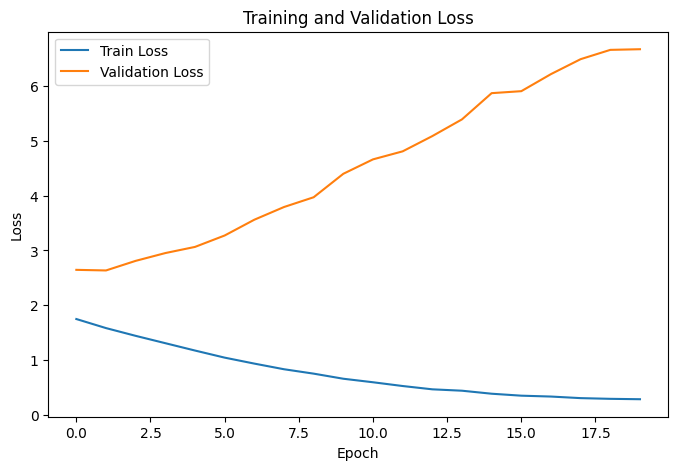

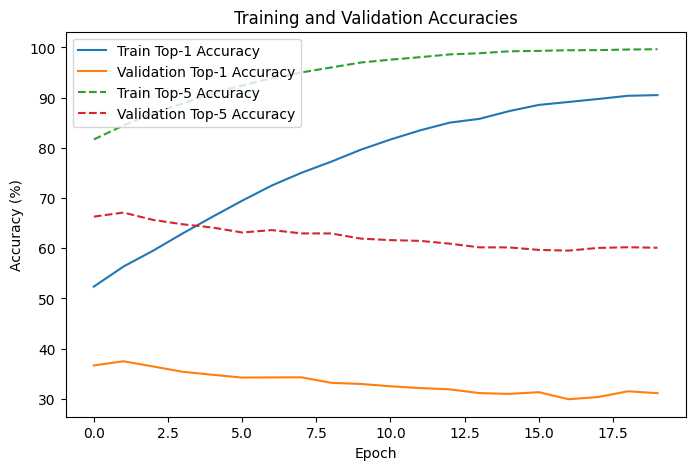

Test Accuracy top-1 and top-5: 31.40% 60.07%


In [ ]:
import matplotlib.pyplot as plt
import tqdm

def plot_loss(train_losses, val_losses):
    # train_losses:    List to store training losses for each epoch
    # val_losses:      List to store validation losses for each epoch

    # plot the training and validation loss
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

def plot_accuries(train_top1, train_top5, val_top1, val_top5):
    # train_top1: List to store training top-1 accuries for each epoch
    # train_top5: List to store training top-5 accuries for each epoch
    # val_top1:   List to store val top-1 accuries for each epoch
    # val_top5:   List to store val top-5 accuries for each epoch

    # plot the training and validation accuries
    plt.figure(figsize=(8, 5))
    plt.plot(train_top1, label='Train Top-1 Accuracy')
    plt.plot(val_top1, label='Validation Top-1 Accuracy')
    plt.plot(train_top5, label='Train Top-5 Accuracy', linestyle='--')
    plt.plot(val_top5, label='Validation Top-5 Accuracy', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracies')
    plt.legend()

    plt.show()

def report_accuracy(test_loader, model):
    correct_top1 = 0
    correct_top5 = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for batch in test_loader:
            # get images and their labels from batch
            images, labels = batch
            # pass your tensor to your device( CPU/GPU)
            images = images.to(next(model.parameters()).device)
            labels = labels.to(next(model.parameters()).device)
            # Implement validation forward pass
            # HINT: Compute predictions and loss
            outputs = model(images)
            # Calculate accuracy
            # HINT: Compare predictions with labels
            _, pred_top1 = outputs.topk(1, dim=1)
            _, pred_top5 = outputs.topk(5, dim=1)
            correct_top1 += (pred_top1.squeeze() == labels).sum().item()
            correct_top5 += sum([labels[i] in pred_top5[i] for i in range(labels.size(0))])
            total += images.size(0)

    accuracy_top1 = (correct_top1 / total) * 100
    accuracy_top5 = (correct_top5 / total) * 100
    return accuracy_top1,accuracy_top5

# call plot_loss and compute_confusion matrix function with appropriate parameters
plot_loss(train_losses, val_losses) # @TODO: modify argument based on your code
plot_accuries(train_accuracies_top1, train_accuracies_top5, val_accuracies_top1,val_accuracies_top5) #TODO: modify argument based on your code

test_accuracy = report_accuracy(test_loader, model) # modify argument based on your code
print(f"Test Accuracy top-1 and top-5: {test_accuracy[0]:.2f}% {test_accuracy[1]:.2f}%")

### **2.7 Change and Finetune Your Model (20 Points)**

* Add BatchNorm2d with learnable parameters after each Conv2D layer.

* Try different optimizers including SGD, Adam.

* Search for a better **learning rate** on the validation data.

* For each combination of model, optimizer and learning settings plot graphs mentioned in Section 2.7.

* For the best parameters, model and optimizer settings, report test accuricies.

* **Discuss your results** with respect to overfitting/underfitting and the impact of the hyper-parameters.

#### **2.7.1 Hyperparameter Optimization (5 Points)**
In this part, you should perform hyperparameter optimization using all possible combinations (grid-search) of the given learning rates, optimizer and BatchNorm2d settings.

First, you are expected re-implement your model in Section 2.2 using BatchNorm2D layer after each convlution layer.

In [ ]:
class CustomCNNwithBN(nn.Module):
    def __init__(self, norm_layer= None):
        super(CustomCNNwithBN, self).__init__()

        # Define layers of CNN implemented in Section 2.3.
        # You should use BatchNorm2D layer after each Conv2D layer.
        # Define layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) # Add BatchNorm2d after conv1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64) # Add BatchNorm2d after conv2
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128) # Add BatchNorm2d after conv3
        self.pool = nn.MaxPool2d(2, 2)
        # The size after the conv and pool layers: Input 32x32 -> conv1 (32x32) -> pool (16x16) -> conv2 (16x16) -> pool (8x8) -> conv3 (8x8)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 100)


    def forward(self, x):

        # Implement the forward pass
        # HINT: Apply activation functions like ReLU where necessary
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

# Create model instance
model_bn = CustomCNNwithBN()

# Print model summary
print(model_bn)

CustomCNNwithBN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=100, bias=True)
)


For each combination, you should retrain your model from scratch and store the loss and accuracies of validation data. **All remaining settings/parameters should be fixed, except for the learning rate, optimizer and BatchNorm2d usage.**

In [ ]:
learning_rates = [0.0001, 0.001]
optimizer_classes = [torch.optim.Adam, torch.optim.SGD]
model_configs = {
     "NoBN": CustomCNN,
    "WithBN": CustomCNNwithBN
}

# Dictionary to store results for each combination
results = {}

# Get the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs_grid_search = 15 # Reduced epochs for grid search for quicker iteration

# implement a nested for loop to make a grid search over the given
# learning_rates, models and optimizers. Do not forget to reinitialize the model
# to avoid weight sharing.

for model_name, model_class in model_configs.items():
    for optimizer_class in optimizer_classes:
        for lr in learning_rates:
            print(f"Training: Model={model_name}, Optimizer={optimizer_class.__name__}, LR={lr}")

            # Reinitialize the model for each run
            model = model_class().to(device)

            # Define the optimizer
            if optimizer_class == torch.optim.SGD:
                 optimizer = optimizer_class(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9) # Added momentum for SGD
            else:
                 optimizer = optimizer_class(model.parameters(), lr=lr, weight_decay=1e-4)

            # Define the loss function (remains the same)
            loss_function = torch.nn.CrossEntropyLoss()

            # Lists to store metrics for this specific run
            run_train_losses, run_val_losses = [], []
            run_train_accuracies_top1, run_train_accuracies_top5 = [], []
            run_val_accuracies_top1, run_val_accuracies_top5 = [], []

            # Training loop for this combination
            for epoch in range(num_epochs_grid_search):
                train_loss, train_top1, train_top5 = train(model, train_loader, optimizer, loss_function, device)
                val_loss, val_top1, val_top5 = validate(model, val_loader, loss_function, device)

                run_train_losses.append(train_loss)
                run_val_losses.append(val_loss)
                run_train_accuracies_top1.append(train_top1)
                run_train_accuracies_top5.append(train_top5)
                run_val_accuracies_top1.append(val_top1)
                run_val_accuracies_top5.append(val_top5)

                # print(f"  Epoch {epoch+1}/{num_epochs_grid_search}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val Top-1={val_top1:.2f}%")


            # Store the results for this combination
            key = f"{model_name}_{optimizer_class.__name__}_lr{lr}"
            results[key] = {
                'train_losses': run_train_losses,
                'val_losses': run_val_losses,
                'train_acc_top1': run_train_accuracies_top1,
                'train_acc_top5': run_train_accuracies_top5,
                'val_acc_top1': run_val_accuracies_top1,
                'val_acc_top5': run_val_accuracies_top5,
                'final_val_acc_top1': val_accuracies_top1[-1] if val_accuracies_top1 else 0 # Store final validation accuracy
            }
            print("-" * 30)

print("Grid search completed.")

Training: Model=WithBN, Optimizer=Adam, LR=0.0001
------------------------------
Training: Model=WithBN, Optimizer=Adam, LR=0.001
------------------------------
Training: Model=WithBN, Optimizer=SGD, LR=0.0001
------------------------------
Training: Model=WithBN, Optimizer=SGD, LR=0.001
------------------------------
Grid search completed.


#### **2.7.2 Choosing best parameters  (5 Points)**
You should choose the parameters that give the highest top-1 accuracy on the validation data. Then, you should plot graph and report metrics mentioned in Section 2.7.




In [ ]:
best_val_accuracy = -1
best_params = None
best_run_key = None

if not results:
    print("Error: The 'results' dictionary is empty. Please run 2.7.1 first.")
else:
    # Iterate through the stored results
    print("Analyzing grid search results...")
    for key, metrics in results.items():
        # The 'val_acc_top1' list stores validation top-1 accuracy per epoch.
        # We want the highest accuracy achieved at any point during the grid search epochs
        # for this specific configuration.
        if 'val_acc_top1' in metrics and metrics['val_acc_top1']: # Ensure the key exists and list is not empty
             current_max_val_accuracy = max(metrics['val_acc_top1'])
        else:
             current_max_val_accuracy = 0 # Assign 0 if no valid accuracy data was recorded for this run

        # Check if this is the best validation accuracy found so far
        if current_max_val_accuracy > best_val_accuracy:
            best_val_accuracy = current_max_val_accuracy
            best_run_key = key
            # Extract params from the key (assuming key format is "ModelName_OptimizerName_lrLRValue")
            try:
                parts = key.split('_')
                best_params = {
                    'model': parts[0],
                    'optimizer': parts[1],
                    'lr': float(parts[2][2:]) # Extract LR value after 'lr'
                }
            except (IndexError, ValueError):
                 print(f"Warning: Could not parse key '{key}'. Skipping this result.")
                 continue # Skip this key if parsing fails


    # Check if a best run was found
    if best_run_key is None:
         print("Could not find a best performing run in the results.")
         print("Please check the 'results' dictionary content and key format.")
    else:
        # Print the best configuration found
        print(f"\nBest performing configuration on validation data (based on max Top-1 accuracy during grid search):")
        print(f"  Key: {best_run_key}")
        print(f"  Maximum Validation Top-1 Accuracy during Grid Search: {best_val_accuracy:.2f}%")
        print(f"  Parameters: {best_params}")


Analyzing grid search results...

Best performing configuration on validation data (based on max Top-1 accuracy during grid search):
  Key: WithBN_Adam_lr0.0001
  Maximum Validation Top-1 Accuracy during Grid Search: 45.11%
  Parameters: {'model': 'WithBN', 'optimizer': 'Adam', 'lr': 0.0001}


#### **2.7.3 Discuss your results (10 Points)**
In this section, you should discuss your results with respect to overfitting/underfitting and the impact of the hyper-parameters.

## **Task 3: Implementing a RNN via torch.autograd (30 Points)**
In this task, you should implement a Recurrent Neural Network (RNN) by manually unrolling an RNN and using PyTorch's `torch.autograd` to compute gradients explicitly.





### **3.1 Input Pre-processing**
In this part, you are expected to process an input string to estimate a given target. We use the string "Deep Learning" for a character-level prediction task. For example:


```
input:  D e e p   L e a r n i n
target: e e p   L e a r n i n g
```

Each character should be converted to a one-hot vector, and the model should predict the next character in the sequence.


In [ ]:
import torch

#######################################################
# 1. Define input text and build vocabulary
#######################################################

text = "Deep Learning"  # Input text for character-level modeling

# Create a sorted list of unique characters.
# 'chars' will contain all unique characters in the input text sorted in alphabetical order
chars = sorted(list(set(text))) # @TODO: modify this line

# Create a mapping from character to index (char2idx) and index to character (idx2char)
# 'char2idx' will map each unique character to a unique index, and 'idx2char' will reverse that mapping
char2idx = {ch: idx for idx, ch in enumerate(chars)} # @TODO: modify this line
idx2char = {idx: ch for idx, ch in enumerate(chars)} # @TODO: modify this line

#######################################################
# 2. Create input and target sequences
#######################################################

# Input: all characters except the last one
# This is the input sequence for the RNN model. The input sequence will be "Deep Learnin"
input_seq = text[:-1]  # @TODO: modify this line

# Target: all characters except the first one
# The target sequence is the same as the input sequence, but shifted by one character.
# The target sequence will be "eep Learning"
target_seq = text[1:]  # @TODO: modify this line

#######################################################
# 3. Define model hyperparameters
#######################################################

V = len(chars)       # Size of character vocabulary. Number of unique characters in the text.
input_size = V       # One-hot input vector size. It's the same as vocab size, as each character is represented as one-hot.
H = 16              # Number of hidden units in the RNN. This defines the dimensionality of the hidden state.
output_size = V      # Output size. For each character in the sequence, we output a score for each possible character.
seq_len = len(input_seq)      # Length of input sequence (i.e., the number of time steps).
                              # This is the number of characters in the input sequence.

# At this point, we have all the necessary components to train an RNN:
# - A list of characters and their mappings to indices
# - The input sequence and corresponding target sequence
# - The hyperparameters that define the model's architecture

#######################################################
# 4. Convert characters to one-hot vectors
#######################################################

def one_hot(idx, size):
    """
    Convert index to one-hot encoded vector of given size.

    Args:
    idx (int): The index of the character in the vocabulary.
    size (int): The size of the one-hot encoded vector, typically equal to V.

    Returns:
    torch.Tensor: A one-hot encoded vector of size 'size' where the element at index 'idx' is 1, and all others are 0.
    """
    #####################################################
    # @TODO: Implement one-hot decoding
    #####################################################
    vec = torch.zeros(size)
    vec[idx] = 1.0
    return vec

# Convert entire input sequence to one-hot encoded tensors
# The input sequence is a string, and each character needs to be converted to a one-hot vector using the 'one_hot' function.
# For each character in the input sequence, its index is retrieved from 'char2idx', and then the corresponding one-hot vector is generated.

inputs = torch.stack([one_hot(char2idx[ch], V) for ch in input_seq]) # @TODO: modify this line (Convert entire input sequence to one-hot encoded tensors)

# Convert target characters to integer labels (indices)
# The target sequence contains the next character for each input character, so each character needs to be mapped to an index.
# This is a typical setup where the model outputs indices, which will later be converted to actual characters.

targets = torch.tensor([char2idx[ch] for ch in target_seq], dtype=torch.long) # @TODO: modify this line (Convert target characters to integer labels (indices))

### **3.2 Implement a Training Pipeline (30 Points)**

In this part, you should implement the following RNN for an autoregressive character prediction problem with the vocabulary size (the number of possible characters) of ${V}$, the hidden state size (the number of hidden units) of ${H}$, and given the input-output pair $(\mathbf{x}=(\mathbf{x}_1, \mathbf{x}_2, ...), y)$ -- e.g., ($\mathbf{x}=($'D', 'e', 'e'$), y=$'p'):

\begin{align*}
\mathbf{h}_t &= \tanh(\mathbf{W}_{xh} \, \mathbf{x}_t + \mathbf{b}_{ih} + \mathbf{W}_{hh} \, \mathbf{h}_{t-1} + \mathbf{b}_{hh}), \\
\mathbf{s}_t &= \mathbf{W}_{hy} \, \mathbf{h}_t + \mathbf{b}_y, \\
\mathbf{\hat{y}}_t &= \text{softmax}(\mathbf{s}_t),
\end{align*}  
where

*      $\mathbf{x}_t$: one-hot encoded input at time step $t$ (size: $V$),
*      $\mathbf{h}_t$: hidden state at time step $t$ (size: $H$),
*      $\mathbf{s}_t$: output logits at time step $t$ (size: $V$),
*      $\mathbf{\hat{y}}_t$: predicted probabilities (size: $V$),
*      $\mathbf{W}_{xh}$: input-to-hidden weight matrix (size: $H \times V$),
*      $\mathbf{W}_{hh}$: hidden-to-hidden weight matrix (size: $H \times H$),
*      $\mathbf{b}_{xh}$: hidden bias (size: $H$),
*      $\mathbf{b}_{hh}$: hidden bias (size: $H$),
*      $\mathbf{W}_{hy}$: hidden-to-output weight matrix (size: $V \times H$),
*      $\mathbf{b}_y$: output bias (size: $V$).

Then, you should calculate **negative log likelihood loss (NLL)** between predicted probabilities ${\mathbf{\hat{y}}}$ and target $\mathbf{y}$:


$${L}_{\text{NLL}} = - \sum_{i=1}^{N} \sum_{c=1}^{V} \mathbf{y}_{ic} \log \mathbf{\hat{y}}_{ic}$$



In [ ]:
###########################################################################
# @TODO: Define W_xh, W_hh, b_xh, b_hh, W_hy and b_y as differentiable tensors.
#        Initialize all weights randomly using a standard normal distribution.
# HINT: Use the given V and H in coding cell of "Section 3.1 Input Pre-processing" to define them.

# Do not modify variables names!
W_xh = torch.randn(H, V, requires_grad=True)   # @TODO: modify this line
W_hh = torch.randn(H, H, requires_grad=True)   # @TODO: modify this line
b_xh = torch.randn(H, requires_grad=True)      # @TODO: modify this line
b_hh = torch.randn(H, requires_grad=True)      # @TODO: modify this line
W_hy = torch.randn(V, H, requires_grad=True)   # @TODO: modify this line
b_y = torch.randn(V, requires_grad=True)       # @TODO: modify this line
###########################################################################

import torch.nn.functional as F

logits_list = []
h = torch.zeros(H)
# Go over each time step to update the hidden state first and then calculate
# the logits
for t in range(seq_len):
    ###########################################################################
    # @TODO: Fill in this part to calculate logits
    # h_t = tanh(W_xh @ x_t + b_xh + W_hh @ h_{t-1} + b_hh)
    # s_t = W_hy @ h_t + b_y
    x_t = inputs[t]
    h = torch.tanh(W_xh @ x_t + b_xh + W_hh @ h + b_hh)
    s_t = W_hy @ h + b_y
    ###########################################################################
    logits_list.append(s_t)

logits = torch.stack(logits_list)
log_probs = F.log_softmax(logits, dim=1)
loss_manual = F.nll_loss(log_probs, targets)

### **3.3 Compute the gradient explicitly via torch.autograd**
In this part, you are expected compute gradient using torch.autograd explicitly for each parameter, i.e. gradients of loss value with respect to:

*   $\mathbf{W}_{xh}$
*   $\mathbf{W}_{hh}$
*   $\mathbf{b}_{xh}$
*   $\mathbf{b}_{hh}$
*   $\mathbf{W}_{hy}$
*   $\mathbf{b}_{y}$



In [ ]:
# Calculate gradient for each parameter, separately.
grad_W_xh = torch.autograd.grad(loss_manual, W_xh, retain_graph=True)[0] # @TODO: modify this line
grad_W_hh = torch.autograd.grad(loss_manual, W_hh, retain_graph=True)[0] # @TODO: modify this line
grad_b_xh = torch.autograd.grad(loss_manual, b_xh, retain_graph=True)[0] # @TODO: modify this line
grad_b_hh = torch.autograd.grad(loss_manual, b_hh, retain_graph=True)[0] # @TODO: modify this line
grad_W_hy = torch.autograd.grad(loss_manual, W_hy, retain_graph=True)[0] # @TODO: modify this line
grad_b_y = torch.autograd.grad(loss_manual, b_y, retain_graph=True)[0]   # @TODO: modify this line

# Now, concatenate the gradients
manual_grads = [grad_W_xh, grad_W_hh, grad_b_xh, grad_b_hh, grad_W_hy, grad_b_y]

### **3.4 Validate Implementation in Section 3.3**
This part is only to validate your implementation in Section 3.3 and see your grade.

**Do not modify/add any code here!**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn_cell = nn.RNNCell(input_size, H)
        self.hidden_size = H
        self.output_layer = nn.Linear(H, output_size)

        with torch.no_grad():
            self.rnn_cell.weight_ih.copy_(W_xh)  # manual weight W_xh matches weight_ih
            self.rnn_cell.weight_hh.copy_(W_hh)
            self.rnn_cell.bias_ih.copy_(b_xh)
            self.rnn_cell.bias_hh.copy_(b_hh)

            self.output_layer.weight.copy_(W_hy)
            self.output_layer.bias.copy_(b_y)

    def forward(self, x_seq):
        h = torch.zeros(self.hidden_size)
        logits = []
        for x in x_seq:
            h = self.rnn_cell(x, h)
            y = self.output_layer(h)
            logits.append(y)
        return torch.stack(logits)

grade = 0
model = SimpleRNN()

logits_ref = model(inputs)
log_probs_ref = F.log_softmax(logits_ref, dim=1)
loss_ref = F.nll_loss(log_probs_ref, targets)
loss_ref.backward()

# ----------------------------
# 5. Compare Gradients
# ----------------------------

param_names = ['W_xh', 'W_hh', 'b_xh', 'b_hh', 'W_hy', 'b_y']
model_grads = []

#get model gradient
for name, param in model.named_parameters():
    if param.grad is not None:
        model_grads.append(param.grad)

for name, g1, g2 in zip(param_names, manual_grads, model_grads):
    diff = (g1 - g2).abs().max()
    print(f"Δ {name}: max abs diff = {diff:.6e}")
    if diff > 1e-4:
        print("❗ Significant difference")
    else:
        grade += 5
print(f" Your grade is {grade}/30")

Δ W_xh: max abs diff = 6.482005e-07
Δ W_hh: max abs diff = 1.072884e-06
Δ b_xh: max abs diff = 8.940697e-07
Δ b_hh: max abs diff = 8.940697e-07
Δ W_hy: max abs diff = 5.960464e-08
Δ b_y: max abs diff = 2.980232e-08
 Your grade is 30/30
